In [22]:
import os
import os.path as osp
import torch
import torch.nn as nn
import torch.optim as opti
from tqdm import tqdm
import torchvision.transforms as T
from generate_pseudo_labels.extract_embedding.model import model
import numpy as np
from scipy import stats
import pdb
from PIL import Image
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,8)


In [3]:
def read_img(imgPath):     # read image & data pre-process
    data = torch.randn(1, 3, 112, 112)
    transform = T.Compose([
        T.Resize((112, 112)),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    img = Image.open(imgPath).convert("RGB")
    data[0, :, :, :] = transform(img)
    return data

def network(eval_model, device):
    net = model.R50([112, 112], use_type="Qua").to(device)
    net_dict = net.state_dict()     
    data_dict = {
        key.replace('module.', ''): value for key, value in torch.load(eval_model, map_location=device).items()}
    net_dict.update(data_dict)
    net.load_state_dict(net_dict)
    net.eval()
    return net

In [10]:
imgpath = './demo_imgs/3.jpg'                         # [1,2,3.jpg]
device = 'cuda:0'                                        # 'cpu' or 'cuda:x'
eval_model = './model/SDD_FIQA_checkpoints_r50.pth'   # checkpoint
net = network(eval_model, device)
input_data = read_img(imgpath).cuda()
pred_score = net(input_data).data.cpu().numpy().squeeze()
print(f"Quality score = {pred_score}")

Quality score = 72.65948486328125


In [12]:
 # Images from surveillance cameras
folder = "/media/rafael/Windows-SSD/recfac/bases/SCFace/SCface_database/surveillance_cameras_all/"
files = glob(folder+"*.jpg")

In [13]:
results={}
for imgPath in tqdm(files):
    key = os.path.splitext(os.path.basename(imgPath))[0]
    labels = key.split("_")
    cam = labels[1]
    if cam not in ["cam6","cam7","cam8"]:
        input_data = read_img(imgPath).cuda()
        dist = labels[2]
            
    # Calculate the quality score of the image
    # T=100 (default) is a good choice
    # Alpha and r parameters can be used to scale your
    # score distribution.
        score = net(input_data).data.cpu().numpy().squeeze()
        results[key] = {"cam":cam, "distance":dist, "quality":score}

100%|██████████| 2860/2860 [00:16<00:00, 170.75it/s]


In [18]:
df = pd.DataFrame.from_dict(results,orient='index',columns=['cam','distance','quality'])
df.head()

,cam,distance,quality
001_cam1_1,cam1,1,34.32835
001_cam1_2,cam1,2,33.673668
001_cam1_3,cam1,3,41.502834
001_cam2_1,cam2,1,48.778934
001_cam2_2,cam2,2,37.554516


array([[<AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>, <AxesSubplot:>]], dtype=object)

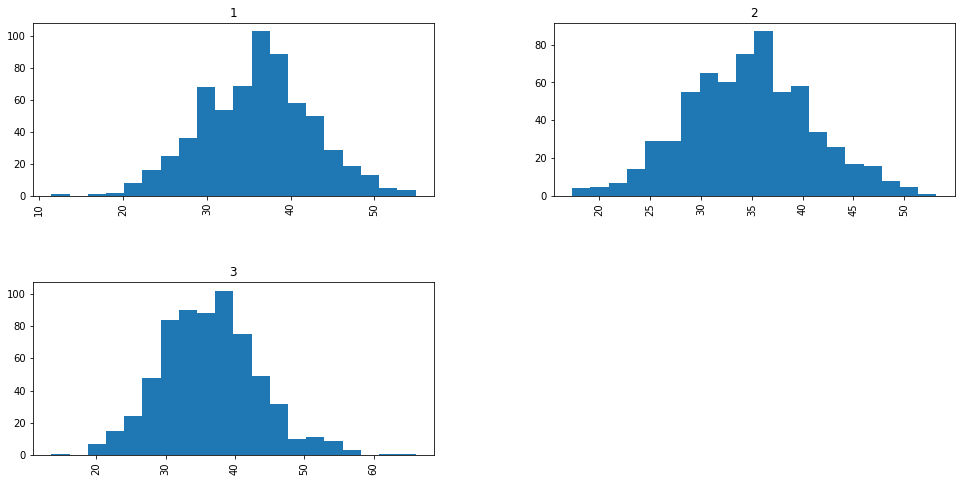

In [23]:
df.hist(column='quality',by=['distance'],bins=20)

array([[<AxesSubplot:title={'center':'(1, cam1)'}>,
        <AxesSubplot:title={'center':'(1, cam2)'}>,
        <AxesSubplot:title={'center':'(1, cam3)'}>,
        <AxesSubplot:title={'center':'(1, cam4)'}>],
       [<AxesSubplot:title={'center':'(1, cam5)'}>,
        <AxesSubplot:title={'center':'(2, cam1)'}>,
        <AxesSubplot:title={'center':'(2, cam2)'}>,
        <AxesSubplot:title={'center':'(2, cam3)'}>],
       [<AxesSubplot:title={'center':'(2, cam4)'}>,
        <AxesSubplot:title={'center':'(2, cam5)'}>,
        <AxesSubplot:title={'center':'(3, cam1)'}>,
        <AxesSubplot:title={'center':'(3, cam2)'}>],
       [<AxesSubplot:title={'center':'(3, cam3)'}>,
        <AxesSubplot:title={'center':'(3, cam4)'}>,
        <AxesSubplot:title={'center':'(3, cam5)'}>, <AxesSubplot:>]],
      dtype=object)

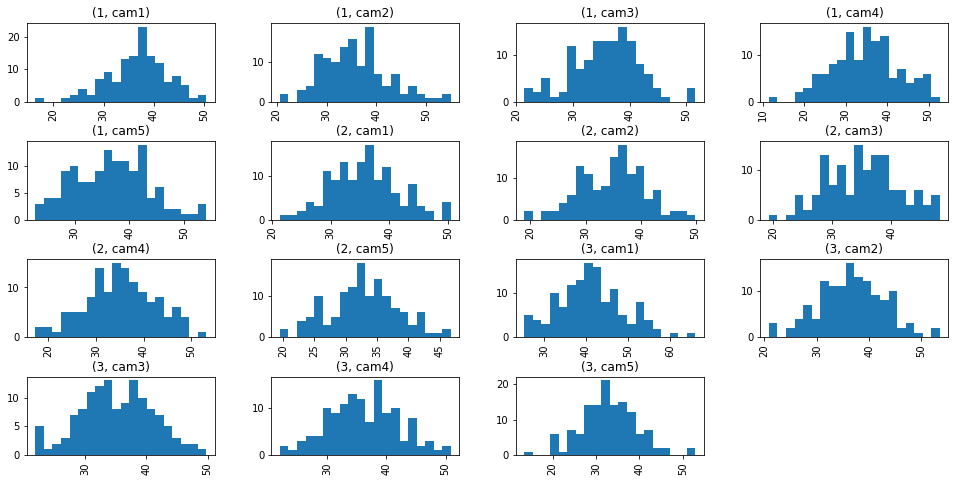

In [24]:
df.hist(column='quality',by=['distance','cam'],bins=20)

In [31]:
# Images from frontal cameras
folder = "/media/rafael/Windows-SSD/recfac/bases/SCFace/SCface_database/mugshot_frontal_cropped_all/"
files = glob(folder+"*.JPG")

In [34]:
results={}
for imgPath in tqdm(files):
    key = os.path.splitext(os.path.basename(imgPath))[0]
    input_data = read_img(imgPath).cuda()
                
    # Calculate the quality score of the image
    # T=100 (default) is a good choice
    # Alpha and r parameters can be used to scale your
    # score distribution.
    score = net(input_data).data.cpu().numpy().squeeze()
    results[key] = score

100%|██████████| 130/130 [00:05<00:00, 24.41it/s]


In [35]:
df2 = pd.DataFrame.from_dict(results,orient='index',columns=['quality'])
df2.head()

,quality
001_frontal,62.532795
002_frontal,39.275806
003_frontal,45.676903
004_frontal,48.604351
005_frontal,45.533470


array([[<AxesSubplot:title={'center':'quality'}>]], dtype=object)

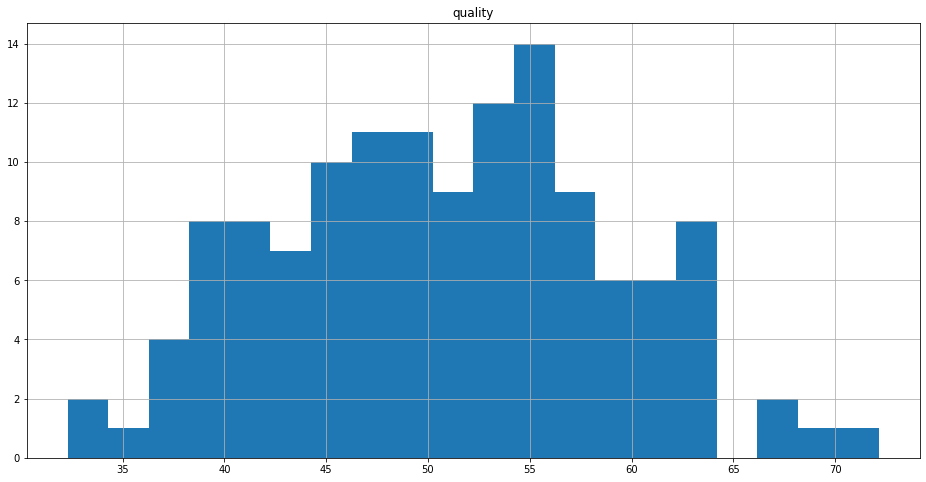

In [36]:
df2.hist(column='quality',bins=20)